In [1]:
import pandas as pd, numpy as np, joblib, shap, matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

df = pd.read_csv("engineered_features_v4.csv")
feature_names = joblib.load("outputs/hotel_feature_names.joblib")

drop_cols = ["is_canceled", "reservation_status_date"]
df = df.drop(columns=[c for c in drop_cols if c in df.columns])
df = df[feature_names]

# Model selection 
model_path = "outputs/hotel_rf_model.joblib"  #  change to any model path
model = joblib.load(model_path)

In [2]:
# ===== Scaler detection (for logistic regression only) =====
scaler = None
if isinstance(model, LogisticRegression) or "logreg" in model_path.lower():
    try:
        scaler = joblib.load("scaler.joblib")
        df_scaled = pd.DataFrame(scaler.transform(df), columns=feature_names)
        X_data = df_scaled
        print("Logistic model detected — using scaled data.")
    except Exception:
        X_data = df
        print("Logistic model detected but scaler missing — using raw data.")
else:
    X_data = df
    print(f" Using model: {type(model).__name__}")


 Using model: RandomForestClassifier


In [3]:
# Select appropriate SHAP explainer 
if isinstance(model, (RandomForestClassifier, XGBClassifier)):
    explainer = shap.TreeExplainer(model)
elif isinstance(model, LogisticRegression):
    explainer = shap.Explainer(model, X_data, feature_names=feature_names)
else:
    raise ValueError("Unsupported model type for SHAP computation.")

# ===== Sampling for low-memory devices =====
X_sample = X_data.sample(n=min(500, len(X_data)), random_state=42)

# ===== Compute SHAP values =====
shap_values = explainer(X_sample)

print(" SHAP values computed with shape:", shap_values.values.shape)


 SHAP values computed with shape: (500, 52, 2)


<Figure size 1000x800 with 0 Axes>

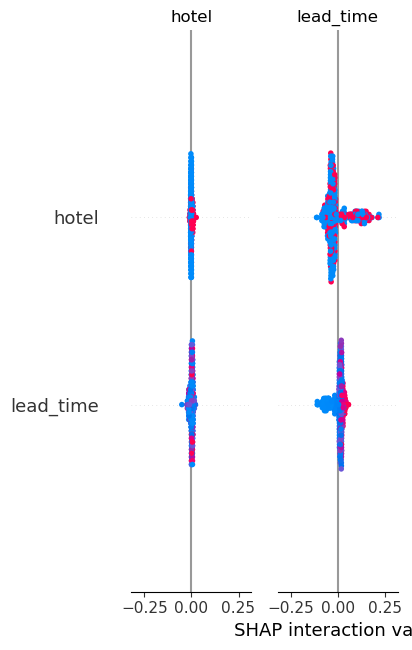

 Global SHAP summary saved as global_shap_summary_RandomForestClassifier.png


In [6]:
plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values.values, X_sample, feature_names=feature_names, show=False)
plt.tight_layout()
filename = f"global_shap_summary_{type(model).__name__}.png"
# plt.savefig(filename, dpi=150)
plt.show()
print(f" Global SHAP summary saved as {filename}")

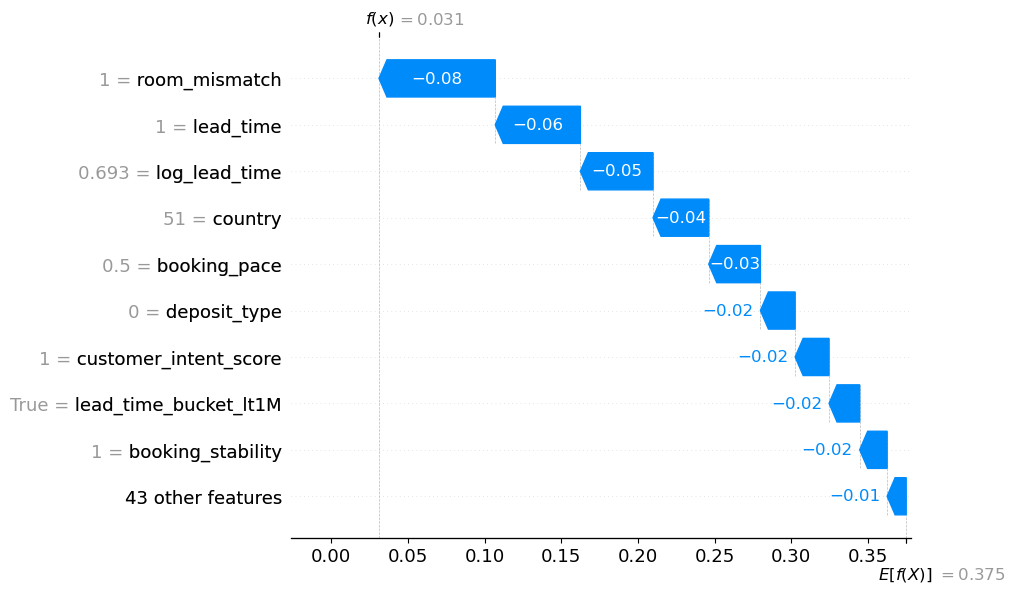

<Figure size 640x480 with 0 Axes>

 Local SHAP waterfall displayed for sample index 1


In [4]:
# Local SHAP Explanation (Single User) 
# class 1 is churn , class 0 is non churn

sample_idx = 1     # user

# If the model has two outputs (binary classification), select class 1
if len(shap_values.values.shape) == 3:  # (n_samples, n_features, n_classes)
    shap_exp = shap_values[..., 1][sample_idx]   # class 1 explanation
    base_val = shap_values.base_values[sample_idx, 1]
else:
    shap_exp = shap_values.values[sample_idx]
    base_val = shap_values.base_values[sample_idx]

# Build SHAP Explanation object for this single instance
explanation = shap.Explanation(
    values=shap_exp,
    base_values=base_val,
    data=X_sample.iloc[sample_idx],
    feature_names=feature_names
)

plt.figure(figsize=(8, 8))
shap.plots.waterfall(explanation)
plt.tight_layout()
# plt.savefig(f"local_shap_waterfall_user_{sample_idx}__class_0.png", bbox_inches='tight', dpi=150)
plt.show()

print(" Local SHAP waterfall displayed for sample index", sample_idx)


In [12]:
# filename = f"shap_values_{type(model).__name__}_universal.joblib"
# joblib.dump(shap_values, filename, compress=3)
# print(f" Saved SHAP values to {filename}")

 Saved SHAP values to shap_values_RandomForestClassifier_universal.joblib


In [23]:
print(type(model), hasattr(model, "predict_proba"))

<class 'sklearn.ensemble._forest.RandomForestClassifier'> True


In [11]:
import warnings
warnings.filterwarnings('ignore')

Computed churn probability range: 0.008658011846545553 → 0.9986744019279097


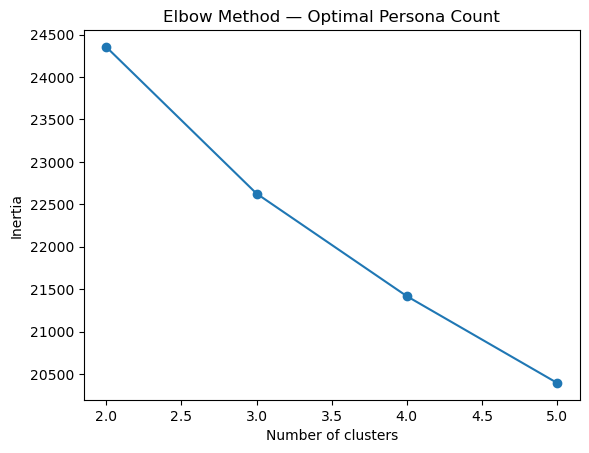

In [12]:
#  PERSONA CLUSTERING BASED ON SHAP + CHURN RISK

import pandas as pd, numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

# Prepare SHAP + feature data 
shap_matrix = np.abs(shap_values.values[..., 1]) if len(shap_values.values.shape) == 3 else np.abs(shap_values.values)
shap_df = pd.DataFrame(shap_matrix, columns=feature_names)

# Ensure X_sample columns are aligned with model feature names
if hasattr(model, "feature_names_in_"):
    required_cols = list(model.feature_names_in_)
    # subset (this will raise if truly missing)
    missing = [c for c in required_cols if c not in X_sample.columns]
    if missing:
        raise ValueError(f"X_sample is missing model columns: {missing[:10]} (first 10 shown). Fix by reconstructing engineered_features_v4.csv with these columns.")
    X_input = X_sample[required_cols]
else:
    X_input = X_sample.copy()

# compute probabilities
if hasattr(model, "predict_proba"):
    y_pred_prob = model.predict_proba(X_input)[:, 1]
    print("Computed churn probability range:", y_pred_prob.min(), "→", y_pred_prob.max())
else:
    raise RuntimeError("Model does not support predict_proba. Cannot compute churn probabilities.")


insight_df = shap_df.copy()
insight_df['churn_risk'] = y_pred_prob

# Optional: scale for balanced clustering
scaler = StandardScaler()
insight_scaled = scaler.fit_transform(insight_df)

#  Optimal cluster count (elbow method, optional) 
# You can skip this for faster runtime
inertias = []
for k in range(2, 6):
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    km.fit(insight_scaled)
    inertias.append(km.inertia_)

plt.plot(range(2, 6), inertias, marker='o')
plt.title('Elbow Method — Optimal Persona Count')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
# plt.savefig('Elbow_method_Optimal_Cluster_Count.png')
plt.show()

In [13]:
#  Final K-Means clustering 
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
persona_labels = kmeans.fit_predict(insight_scaled)

insight_df['persona'] = persona_labels
X_sample['persona'] = persona_labels
X_sample['churn_risk'] = y_pred_prob

print(" Personas created:", insight_df['persona'].unique())

 Personas created: [1 0 2]


In [14]:
#  Persona summary table 
persona_summary = (
    X_sample.groupby('persona')[['churn_risk'] + feature_names]
    .mean()
    .sort_values('churn_risk', ascending=False)
)

display(persona_summary.head(10))

,churn_risk,hotel,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,adr_dev_by_segment,seasonal_cxl_rate,price_segment_Low,price_segment_Medium,price_segment_Very High,price_segment_Very Low,lead_time_bucket_3-6M,lead_time_bucket_6-12M,lead_time_bucket_lt1M,lead_time_bucket_gt1Y
persona,,,,,,,,,,,,,,,,,,,,,
2,0.747150,0.232000,192.864000,0.904000,6.312000,28.512000,16.90400,0.736000,2.448000,1.792000,...,-5.371758,0.376460,0.232000,0.208000,0.016000,0.392000,0.192000,0.424000,0.096000,0.096000
1,0.312618,0.369338,95.909408,1.271777,5.257840,27.010453,15.02439,1.142857,2.968641,1.979094,...,3.918306,0.375381,0.170732,0.177700,0.261324,0.167247,0.247387,0.125436,0.219512,0.017422
0,0.097666,0.431818,2.647727,1.102273,5.363636,26.761364,14.25000,0.477273,1.625000,1.647727,...,-8.739545,0.364522,0.193182,0.204545,0.181818,0.261364,0.000000,0.000000,1.000000,0.000000


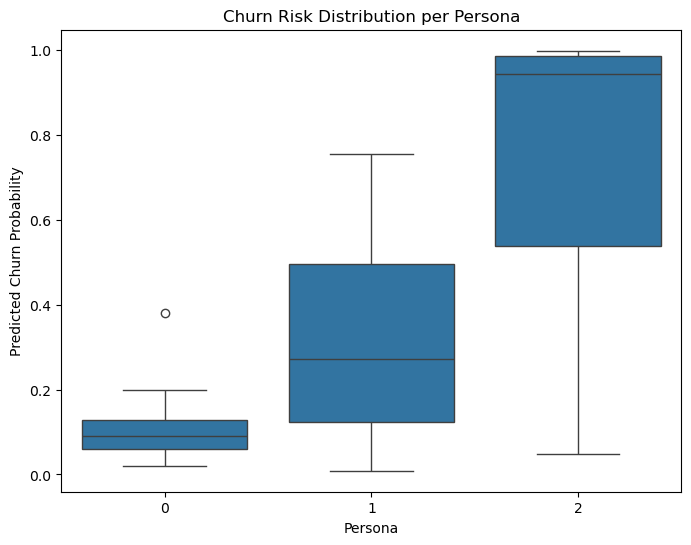

In [16]:
#  Visualize Personas 
plt.figure(figsize=(8, 6))
sns.boxplot(x='persona', y='churn_risk', data=X_sample)
plt.title('Churn Risk Distribution per Persona')
plt.xlabel('Persona')
plt.ylabel('Predicted Churn Probability')
# plt.savefig('Churn_prediction_per_persona.png')
plt.show()

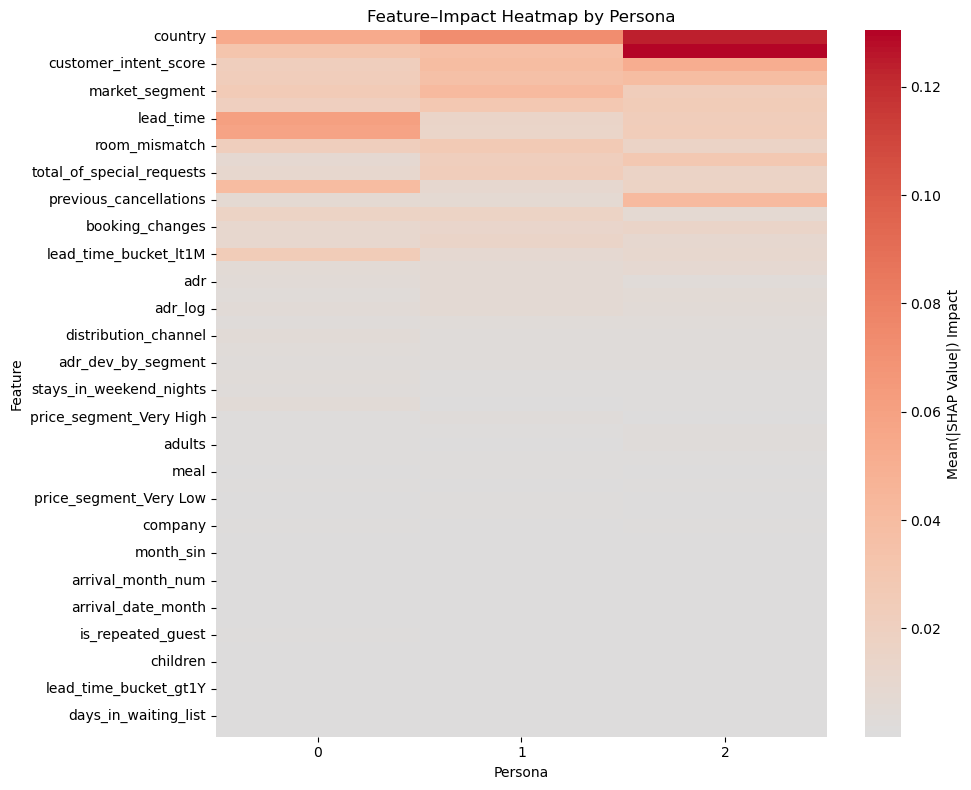

In [18]:
#  FEATURE–IMPACT HEATMAP (GLOBAL + PER-PERSONA)

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

#  Aggregate SHAP values 
# Take absolute mean SHAP values across samples for each feature
shap_matrix = shap_values.values[..., 1] if len(shap_values.values.shape) == 3 else shap_values.values
shap_df = pd.DataFrame(np.abs(shap_matrix), columns=feature_names)

# Add persona + churn_risk context
shap_df['persona'] = X_sample['persona'].values
shap_df['churn_risk'] = X_sample['churn_risk'].values

# Compute average SHAP by persona 
persona_shap = (
    shap_df.groupby('persona')[feature_names]
    .mean()
    .T  # transpose: features as rows
)

# Sort features by overall importance 
feature_order = shap_df[feature_names].mean().sort_values(ascending=False).index
persona_shap = persona_shap.loc[feature_order]

# Plot heatmap 
plt.figure(figsize=(10, 8))
sns.heatmap(persona_shap, cmap='coolwarm', center=0,
            cbar_kws={'label': 'Mean(|SHAP Value|) Impact'})
plt.title('Feature–Impact Heatmap by Persona')
plt.xlabel('Persona')
plt.ylabel('Feature')
plt.tight_layout()
# plt.savefig("feature_impact_heatmap_by_persona.png", bbox_inches='tight', dpi=150)
plt.show()

In [20]:
#  PERSONA-LEVEL FEATURE EXPLAINER (TEXT INSIGHT GENERATOR)

import numpy as np
import pandas as pd

# Prepare SHAP data by persona -----
# Use signed mean SHAP values (not absolute) to preserve direction
shap_matrix_signed = shap_values.values[..., 1] if len(shap_values.values.shape) == 3 else shap_values.values
shap_df_signed = pd.DataFrame(shap_matrix_signed, columns=feature_names)
shap_df_signed['persona'] = X_sample['persona'].values

# Mean signed SHAP value per persona
persona_feature_effect = shap_df_signed.groupby('persona')[feature_names].mean().T

# Identify top +ve and -ve features 
N = 3  # top N increasing/decreasing features to list
persona_insights = {}

for persona in persona_feature_effect.columns:
    feature_effects = persona_feature_effect[persona].sort_values(ascending=False)
    top_positive = feature_effects.head(N)   # increase churn
    top_negative = feature_effects.tail(N)   # decrease churn

    insight_text = []
    insight_text.append(f" **Persona {persona}**")
    insight_text.append(f"→ Avg churn risk: {X_sample.loc[X_sample['persona']==persona, 'churn_risk'].mean():.2f}")
    insight_text.append("Top drivers **increasing churn**:")
    for feat, val in top_positive.items():
        insight_text.append(f"  - {feat.replace('_',' ')} (+{val:.3f})")
    insight_text.append("Top stabilizers **reducing churn**:")
    for feat, val in top_negative.items():
        insight_text.append(f"  - {feat.replace('_',' ')} ({val:.3f})")

    persona_insights[persona] = "\n".join(insight_text)

# Display insights 
for p, text in persona_insights.items():
    print("\n" + "="*80)
    print(text)

# Save to file (optional) 
insight_table = pd.DataFrame([
    {"persona": p, "insight_text": t}
    for p, t in persona_insights.items()
])
# insight_table.to_csv("persona_insights_summary.csv", index=False)
# print("\n Saved summary to persona_insights_summary.csv")


 **Persona 0**
→ Avg churn risk: 0.10
Top drivers **increasing churn**:
  - country (+0.006)
  - customer type (+0.004)
  - booking stability (+0.004)
Top stabilizers **reducing churn**:
  - booking pace (-0.040)
  - log lead time (-0.058)
  - lead time (-0.061)

 **Persona 1**
→ Avg churn risk: 0.31
Top drivers **increasing churn**:
  - lead time (+0.011)
  - log lead time (+0.010)
  - booking pace (+0.005)
Top stabilizers **reducing churn**:
  - customer intent score (-0.009)
  - country (-0.034)
  - deposit type (-0.037)

 **Persona 2**
→ Avg churn risk: 0.75
Top drivers **increasing churn**:
  - country (+0.108)
  - deposit type (+0.070)
  - customer intent score (+0.050)
Top stabilizers **reducing churn**:
  - agent (-0.007)
  - customer type (-0.011)
  - market segment (-0.020)

 Saved summary to persona_insights_summary.csv


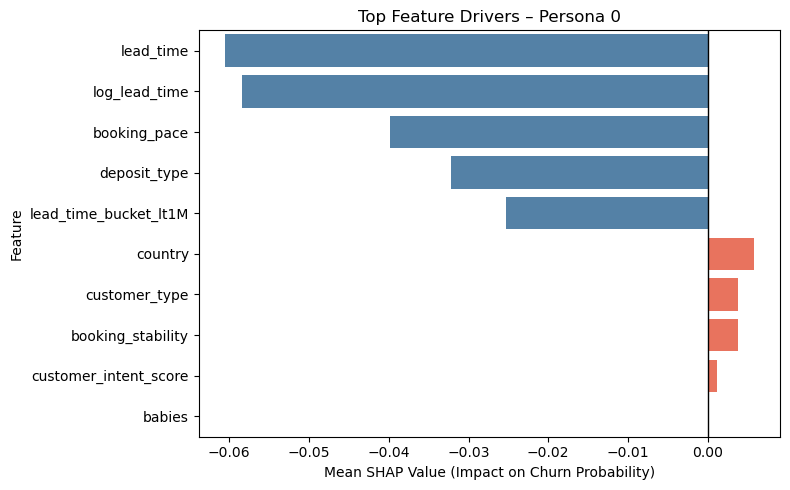

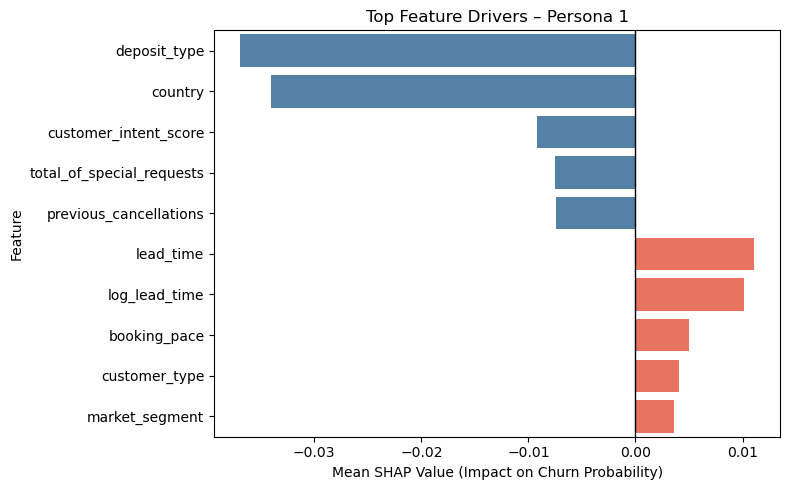

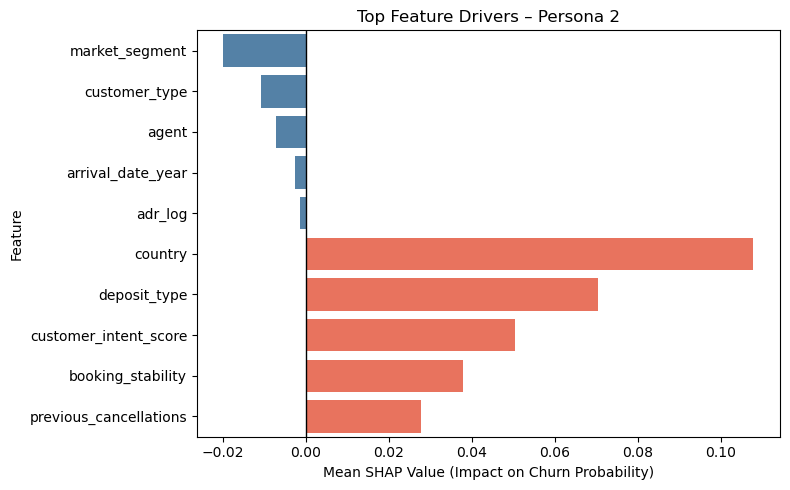

In [21]:
#  VISUAL: TOP FEATURE DRIVERS PER PERSONA (HORIZONTAL BARS)

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Extract signed mean SHAP values per persona 
persona_feature_effect = shap_df_signed.groupby('persona')[feature_names].mean().T

#  Plot top drivers for each persona 
N = 5  # number of features to show per side (+/-)

for persona in persona_feature_effect.columns:
    feature_effects = persona_feature_effect[persona].sort_values(ascending=False)
    top_positive = feature_effects.head(N)
    top_negative = feature_effects.tail(N).sort_values(ascending=True)

    # Combine
    top_features = pd.concat([top_negative, top_positive])

    plt.figure(figsize=(8, 5))
    sns.barplot(
        x=top_features.values,
        y=top_features.index,
        palette=["steelblue" if v < 0 else "tomato" for v in top_features.values]
    )
    plt.axvline(0, color='black', lw=1)
    plt.title(f"Top Feature Drivers – Persona {persona}")
    plt.xlabel("Mean SHAP Value (Impact on Churn Probability)")
    plt.ylabel("Feature")
    plt.tight_layout()
    plt.show()
